In [38]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import os
from SmilesPE.pretokenizer import atomwise_tokenizer
from os import path as p
import torchtext
from collections import OrderedDict
import math
import torch.nn.functional as f
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.optim.lr_scheduler import ReduceLROnPlateau
import selfies as sf


In [39]:
START_TOKEN = '<start>'
END_TOKEN = '<end>'
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [40]:
TOKENS = {
    'Al', 'As', 'B', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'K', 'Li', 'N',
    'Na', 'O', 'P', 'S', 'Se', 'Si', 'Te',
    '(', ')', '[', ']', '=', '#', '%', '0', '1', '2', '3', '4', '5',
    '6', '7', '8', '9', '+', '-', 'se', 'te', 'c', 'n', 'o', 'p', 's', 
    '@@', '@', '\\', '/', '.'
}

special_tokens = [PAD_TOKEN, UNK_TOKEN, START_TOKEN, END_TOKEN]
VOCAB = torchtext.vocab.vocab(ordered_dict=OrderedDict({e:1 for e in TOKENS}), specials=special_tokens)
VOCAB.set_default_index(VOCAB[UNK_TOKEN])




In [41]:
TOKENS = {'[#Branch1]', '[#Branch2]', '[#C-1]', '[#C]', '[#N+1]', '[#N]', '[=As]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N+1]', '[=N-1]', '[=NH1+1]', '[=NH2+1]', '[=N]', '[=O+1]', '[=O]', '[=P+1]', '[=PH1]', '[=P]', '[=Ring1]', '[=Ring2]', '[=S+1]', '[=SH1]', '[=S]', '[=Se+1]', '[=Se]', '[=Te+1]', '[Al]', '[As]', '[B-1]', '[BH1-1]', '[BH2-1]', '[BH3-1]', '[B]', '[Br]', '[Branch1]', '[Branch2]', '[C+1]', '[C-1]', '[CH1-1]', '[C]', '[Cl+3]', '[Cl]', '[F]', '[H]', '[I+1]', '[I]', '[N+1]', '[N-1]', '[NH1+1]', '[NH1-1]', '[NH1]', '[NH2+1]', '[N]', '[Na]', '[O+1]', '[O-1]', '[OH0]', '[OH1+1]', '[O]', '[P+1]', '[PH1]', '[P]', '[Ring1]', '[Ring2]', '[S+1]', '[S-1]', '[SH1]', '[S]', '[Se+1]', '[SeH1]', '[Se]', '[Si]', '[Te]'}
special_tokens = [PAD_TOKEN, UNK_TOKEN, START_TOKEN, END_TOKEN]
VOCAB = torchtext.vocab.vocab(ordered_dict=OrderedDict({e:1 for e in TOKENS}), specials=special_tokens)
VOCAB.set_default_index(VOCAB[UNK_TOKEN])

In [46]:
# smiles to selfies
in_path = 'dataset/chembl28-cleaned.smi'
out_path = 'selfies/chembl28.selfies'

with open(in_path, 'r') as in_f:
    break #####################################################
    with open(out_path, 'w') as out_f:
        for l in in_f:
            if 'smile' in l: continue
            
            r = sf.encoder(l.split()[0])
            if r is not None:
                out_f.write(r + '\n')

In [5]:

def tokenize(smiles, tokens: set= None):
    """
    Takes a SMILES string and returns a list of tokens.
    Atoms with 2 characters are treated as one token. The 
    logic references this code piece:
    https://github.com/topazape/LSTM_Chem/blob/master/lstm_chem/utils/smiles_tokenizer2.py
    """
    if tokens == None: tokens = TOKENS

    n = len(smiles)
    tokenized = []
    i = 0

    # process all characters except the last one
    while (i < n - 1):
        # procoss tokens with length 2 first
        c2 = smiles[i:i + 2]
        if c2 in tokens:
            tokenized.append(c2)
            i += 2
            continue

        # tokens with length 1
        c1 = smiles[i]
        if c1 in tokens:
            tokenized.append(c1)
            i += 1
            continue

        # for unk
        tokenized.append(UNK_TOKEN)
        i += 1

    # process last character if there is any
    if i == n:
        pass
    elif i == n - 1 and smiles[i] in tokens:
        tokenized.append(smiles[i])
    else:
        tokenized.append(UNK_TOKEN)
        
    return tokenized



In [49]:
# Dataset creation
class SmilesDataset(Dataset):
    def __init__(self, smiles_dir, vocab=None, tokens=None, max_len=None): # start and end tokens are added
        '''
        if vocab is None : getVocab() is used
        if max_len is None: take max_len from dataset
        if max_len == 'avg': take average length from dataset
        '''
        if vocab is None: vocab = VOCAB
        self.vocab = vocab

        smiles_files = os.listdir(smiles_dir)
        # reading smiles from files
        tokenized_sen = []
        for file_name in smiles_files:
            with open(p.join(smiles_dir, file_name)) as f:
                for l in f:
                    if ("smile" not in l) and (l != ''):
                        #tokenized_sen.append(tokenize(l.split()[0], tokens))
                        tokenized_sen.append(list(sf.split_selfies(l.split()[0])))
        
        if max_len is None: max_len = max([len(sen) for sen in tokenized_sen])
        if max_len == 'avg': max_len = int(sum([len(sen) for sen in tokenized_sen])/len(tokenized_sen))

        # stripping
        tokenized_sen = [sen[: max_len-2] for sen in tokenized_sen]

        # adding start and end tokens
        tokenized_sen = [[START_TOKEN] + sen + [END_TOKEN] for sen in tokenized_sen]

        # padding
        tokenized_sen = [sen + [PAD_TOKEN]*(max_len-len(sen)) for sen in tokenized_sen]

        # addention mask false at <pad> tokem, true at non pad token
        self.pad_masks = torch.tensor([[PAD_TOKEN==tok for tok in sen] for sen in tokenized_sen])

        # converting to index
        self.data = torch.tensor([self.vocab(sen) for sen in tokenized_sen], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {'idx': self.data[idx], 'pad_mask': self.pad_masks[idx]}

In [50]:
dataset = SmilesDataset('selfies', VOCAB, TOKENS, max_len=100)

In [51]:
classes = [0]*100

all_x = []
for i in range(0, len(dataset)):
    if (i+1)%100000 == 0: print(i)
    all_x.append(dataset[i]['idx'])

99999
199999
299999
399999
499999


In [52]:
all_x = torch.concat(all_x)

In [53]:
for i in range(100):
    classes[i] = (all_x == i).sum()

In [54]:
classes[1]

tensor(0)

In [55]:
len(dataset)

538247

In [56]:
split_ratio = 0.8
split_seed = 42
train_ds, valid_ds = random_split(dataset, [int(len(dataset)*split_ratio), len(dataset)-int(len(dataset)*split_ratio)], generator=torch.Generator().manual_seed(split_seed))

In [20]:
len(dataset)

538247

In [57]:
len(VOCAB)

79

# model

In [69]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    
    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x.transpose(0, 1)
        x = x + self.pe[:x.size(0)]
        x = x.transpose(0, 1)
        return self.dropout(x)



class DecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward,  dropout=0.1):
        super().__init__()
        self.multihead = nn.MultiheadAttention(embed_dim=d_model, 
                                               num_heads=nhead, 
                                               dropout=dropout, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout2 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout3 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)
    
    def forward(self, x, attn_mask, pad_mask):
        x = x + self.dropout1(self.multihead(x, x, x, key_padding_mask=pad_mask, attn_mask=attn_mask, need_weights=False)[0])
        x = self.norm1(x)

        x = x + self.dropout3(self.linear2(self.dropout2(self.linear1(x))))
        x = self.norm2(x)

        return x
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, dim_feedforward, num_layers=1, dropout=0.1, max_len=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model=d_model, dropout=dropout, max_len=max_len)
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, nhead, dim_feedforward) for i in range(num_layers)])
        #self.gru = nn.GRU(d_model, 512, batch_first=True, num_layers=3)
        self.linear = nn.Linear(d_model, vocab_size)
        
        
    def getDevice(self):
        ''' return device of model
        '''
        device = next(self.parameters()).device

        if device.index is None:
            return device.type
        else:
            return device.type + ":" + str(device.index) 

    def generate_square_subsequent_mask(self, sz:int) -> torch.Tensor:
        r"""Generate a square causal mask for the sequence.

        The masked positions are filled with float('-inf'). Unmasked positions are filled with float(0.0).
        device_ordinal = {-1: cpu, 0..inf=>gpu}
        """
        
        return torch.triu(
            torch.full((sz, sz), float('-inf'), dtype=torch.float, device=self.getDevice()),
            diagonal=1,
        )


    def forward(self, x, pad_mask=None):
        ''' x = batch * seq_len
            pad_mask = batch*seq_len
        '''
        seq_len = x.shape[1]
        attn_mask = self.generate_square_subsequent_mask(seq_len)
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for layer in self.decoder_layers:
            x = layer(x, attn_mask=attn_mask, pad_mask=pad_mask)

        #x, _ = self.gru(x)
        x = self.linear(x)
        return x
    
    def generateSmiles(self, batch_size, vocab, max_len=100):
        x = torch.full((batch_size, 1), vocab[START_TOKEN]).to(self.getDevice())
        
        for i in range(1, max_len+1):
            out = self.forward(x)[:, -1]
            out = f.softmax(out, dim=1)
            out = torch.multinomial(out, 1)
            x = torch.cat((x, out), dim=1)
        
        x = x.detach().cpu().tolist()
        # converting idx to smiles
        results = []
        for i in range(batch_size):
            sentance = vocab.lookup_tokens(x[i])
            
            new_sentance = [] # removing special chars
            for i in range(1, len(sentance)):
                e = sentance[i]
                if e==END_TOKEN: break
                if e==START_TOKEN or e==PAD_TOKEN or e==UNK_TOKEN:
                    new_sentance = ['invalid']
                    break
                
                new_sentance.append(e)
            
            results.append(new_sentance)
        
        return results
    


In [75]:
model = Decoder(vocab_size=len(VOCAB), 
        d_model=256, 
        nhead=8, 
        dim_feedforward=128, 
        num_layers=3, 
        dropout=0.1, 
        max_len=100)

model = model.to(DEVICE)
batch_size = 512

train_loader = DataLoader(train_ds, batch_size)
val_loader = DataLoader(valid_ds, batch_size)

criterion = nn.CrossEntropyLoss(reduction='sum', ignore_index=VOCAB[PAD_TOKEN])
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# learning rate scheduler
scheduler = ReduceLROnPlateau(
    optimizer, mode='min',
    factor=0.5, patience=5,
    cooldown=10, min_lr=0.0001
)

train_result = []
val_result = []
epoch  = 10

In [76]:
for i in range(10):
    tl = train(model, optimizer, criterion, train_loader)
    vl = 0# valid(model, criterion, val_loader)
    scheduler.step(tl)
    train_result.append(tl)
    val_result.append(vl)

    print("Epoch:", i+1, "train loss:", tl, "val loss:", vl)




/home/arul/.conda/envs/anshul/lib/python3.12/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


45268.23046875
41495.9765625
38773.0625
37727.9296875
36656.76953125
36404.17578125
35922.69140625
34056.37109375
Epoch: 1 train loss: 39356.730676501495 val loss: 0
33485.82421875
34097.77734375
32917.89453125
32889.9296875
32679.51171875
32801.46484375
32595.935546875
31262.380859375
Epoch: 2 train loss: 32638.335593941658 val loss: 0
31031.439453125
31722.892578125
30800.7265625
30928.021484375
30697.224609375
31048.435546875
30984.931640625
29799.828125
Epoch: 3 train loss: 30596.003144252896 val loss: 0
29410.708984375
30311.81640625
29521.060546875
29777.884765625
29820.37109375
29938.37890625
29910.099609375
28829.197265625
Epoch: 4 train loss: 29422.999755098248 val loss: 0
28529.20703125
29544.3671875
28625.05078125
28940.982421875
28869.130859375
29155.552734375
29120.375
28178.53125
Epoch: 5 train loss: 28627.857747746195 val loss: 0
27922.591796875
28973.619140625
28206.02734375
28314.234375
28111.458984375
28538.919921875
28483.234375
27721.58984375
Epoch: 6 train loss: 28

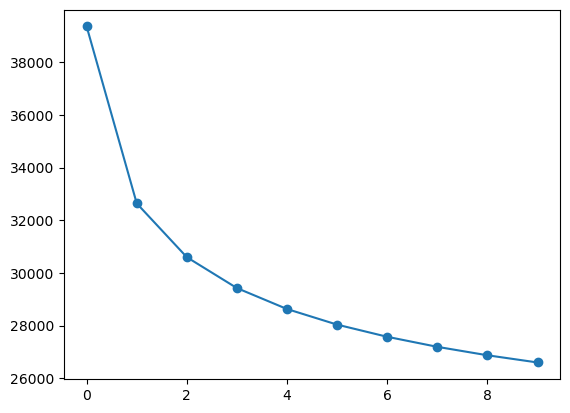

In [77]:
plt.plot(train_result, marker='o')

In [72]:
smiles = model.generateSmiles(batch_size=100, vocab=VOCAB)

for e in smiles:
    smile = "".join(e)
    print(sf.decoder(smile))
    

COC=CC=C(C1=CN=CC=C1CCCN2C(=O)C3=CC=CC=C32)CCl
COC=CCC=CC1=C(NNC(=O)C=C2C3=C(Cl)C=CC=N3)N=CCCCC=CC=C2C=N1
O=CCOC1CCNC=C1CCS(=O)(=O)C=CC2C3=CC=CC=C3CCC2C=CC=CS
C1=2C(CC(=O)C(C)CNC=O)C=C1C=2C=NCC
CCCCCC1=NC(N)C(=C)C1(C(=O)OCCCOC=CC=C(O)C=N)CCCC2=CC=CC=C2S
COC=C1C=CCNC(=O)NCC(=O)C=CC1(NNCC(=O)[NH1]C)CCC(=O)NCCNCC2CC(C)CC2
CC1C(OC)C=CC1C#N
O=C(CNC(=O)C(C)CCC(C)CC1C2)C(O)C=CC(Br)=C2NCNC=CC=CC(=O)OCC=C(F)C(F)=C1CC(F)C
N=C(S)C=O
C1OC=CC=C2CNOC2(CSCC=C1C3)CC(C)CC3CC=O
O=CC1(O)C=CC=C1C(=O)CC[NH1]N=C(C2=CC=CC=C2)NN=CC=C3CC4=CC=CC=C4C=N3
CS(=O)(=C)C=C(C(C12CC=CC(=C1)C)=CC=CC3=CC=CC=C3C(C4=CC=CC=C4CC2CCC)C)CC=O
N#CC=CC=CNC=CC=C(C)Cl
C1C=NN=C(C=O)CCCC=C1
CC(C)CC(C(=O)N1CC2C3SC(=O)NC=NC=CC=C(Cl)C)=C3N2C=C(OS)C1=C
CCCCCCCCNC(=O)CCOCCOCC=CS(=O)(=O)C1=CC=CC=C1CCCCNC=N
CC(C)CC(CCC1CCCC=C1N)C=C(C)CC2=CC=CC=C2[N+1](=O)[O-1]
CCN(C#N)C=C1C=CC=C1N2CC=CC=C(C3)N23
CC(C)CCNCC=C1C(=O)ONC2=C(CN=C2NC=C)C=C1[NH1]C=C=CC=CC=C
CC(=O)C1=CC=C2C=C1NC(=O)C=CC=C(O3)C2C=CC=C3
COCC=CC(C(=O)N)C(C)CCCCC(N)=O
CC=CCCC1CNC(=O)CC1

In [61]:
# Training function
def train(model, optimizer, criterion, train_loader):
    model.train()
    total_loss = 0
    count = 200
    for e in train_loader:
        x = e['idx'].to(DEVICE)
        pad_mask = e['pad_mask'].to(DEVICE)

        x_input = x[:, :-1]
        pad_mask = pad_mask[:, :-1]
        y_expected = x[:, 1:]
        output = model(x_input, pad_mask)
        #print(output.shape, y_expected.shape)

        output = torch.flatten(output, start_dim=0, end_dim=1)
        y_expected = torch.flatten(y_expected, start_dim=0, end_dim=1)
        loss = criterion(output, y_expected)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        count += 1
        if (count+1)%100 == 0: print(loss.item())
        
    total_loss = total_loss/len(train_loader)
    
    return total_loss

# valid function
def valid(model, criterion, val_loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for e in val_loader:
            x = e['idx'].to(DEVICE)
            pad_mask = e['pad_mask'].to(DEVICE)

            x_input = x[:, :-1]
            pad_mask = pad_mask[:, :-1]
            y_expected = x[:, 1:]

            output = model(x_input, pad_mask)
            
            output = torch.flatten(output, start_dim=0, end_dim=1)
            y_expected = torch.flatten(y_expected, start_dim=0, end_dim=1)
            loss = criterion(output, y_expected)

            total_loss += loss.item()
        
    total_loss = total_loss/len(val_loader)
   
    return total_loss
    

In [44]:
m = Decoder(10, 10, 1, 10)

m.to(device='cuda')

Decoder(
  (embedding): Embedding(10, 10)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder_layers): ModuleList(
    (0): DecoderLayer(
      (multihead): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=10, out_features=10, bias=True)
      (dropout2): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=10, out_features=10, bias=True)
      (dropout3): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    )
  )
)

In [46]:
m.generateSmiles(100, getVocab(), 10)

[['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 [],
 ['invalid'],
 ['invalid'],
 [],
 [],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 [],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 [],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 [],
 ['invalid'],
 [],
 ['invalid'],
 ['invalid'],
 [],
 ['invalid'],
 ['=', 'C', '/'],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 [],
 ['invalid'],
 [],
 ['invalid'],
 [],
 ['invalid'],
 [],
 [],
 ['invalid'],
 ['invalid'],
 ['\\'],
 ['invalid'],
 ['=', '\\'],
 ['invalid'],
 ['/', 'C', '/', 'O'],
 [],
 ['\\'],
 ['invalid'],
 ['invalid'],
 [],
 ['invalid'],
 ['/'],
 ['invalid'],
 ['invalid'],
 [],
 ['invalid'],
 ['invalid'],
 ['invalid'],
 [],
 ['\\', '/'],
 ['invalid'],
 ['invalid'],
 [],
 ['invalid'],
 ['

In [ ]:
m.

In [61]:
m.to("cuda:1")

Decoder(
  (embedding): Embedding(10, 10)
  (decoder_layers): ModuleList(
    (0): DecoderLayer(
      (multihead): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=10, out_features=10, bias=True)
      (dropout2): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=10, out_features=10, bias=True)
      (dropout3): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    )
  )
)

In [ ]:
m.

In [56]:
print(next(m.parameters()).device.index)

None


In [55]:
None

In [48]:
x = next(m.parameters()).device

In [49]:
x

device(type='cuda', index=1)

In [51]:
x.index

1

In [16]:
torch.full((2, 3), 4)

tensor([[4, 4, 4],
        [4, 4, 4]])

In [4]:
torch.tril(torch.ones(4, 4))

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

In [5]:
torch.triu(
        torch.full((4, 4), float('-inf'), dtype=torch.float),
        diagonal=1,
    )

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [9]:
mask.get_device()

-1

In [6]:
mask = torch.tril(torch.ones(4, 4) == 1)
mask = mask.float()
mask = mask.masked_fill(mask == 0, float('-inf')) 
mask = mask.masked_fill(mask == 1, float(0.0))

mask

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [15]:
mask.to(device='cpu')

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [ ]:
torch.tril(torch.ones(4, 4) == 1)

tensor([[ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True,  True]])

In [5]:
torch.ones(4, 4) == 1

tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])

In [29]:
torch.nn.TransformerDecoderLayer(d_model=10, nhead=1)

TransformerDecoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
  )
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
  )
  (linear1): Linear(in_features=10, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=10, bias=True)
  (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
)